In [1]:
import collections
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import os
import pickle
from scipy.spatial.distance import squareform
from scipy import stats
from sklearn import manifold
import kernels
from tqdm.notebook import tqdm
import glob
%matplotlib inline
mpl.style.use('../scrartcl.mplstyle')

# Load the data
def load_result(filename, print_=True):
    try:
        with open(filename, 'rb') as fp:
            result = pickle.load(fp)
            if(print_):
                print(f'loaded results from {filename} generated with arguments:\n{result["args"]}')
            return result
    except FileNotFoundError:
        print(f'couldn\'t load results from {filename}')

# Embedding figure

In [2]:
# Specify specific files for reproducibility; the actual files are irrelevant
datasets = [
    ("GSS '04", '../workspace/gss/433ecdab254e30105557e50b862ff4a2298b29bd.pkl'),
    ("ALP '09", '../workspace/alp/40aa0ace5d9ba144e8dbeced60ffbb4f8f810353.pkl'),
    ("BHPS '92", '../workspace/usoc_bb/2d07e29b09affa578ab973d0140b81731f3b147a.pkl'),
    ("BHPS '94", '../workspace/usoc_bd/4c696637d38402d2da070366d5d8aedc788a2246.pkl'),
    # Excluded because no distance
    # ("BHPS '96", '../workspace/usoc_bf/39037edb2d3fec6606b2669c1579dff45383636c.pkl'),
    ("BHPS '98", '../workspace/usoc_bh/6a9139f74e31c37d3337651bb6cf8b39317af7cf.pkl'),
    ("BHPS '00", '../workspace/usoc_bj/ba23eabebbe82fa9bf66637352f0d63b1966a6a1.pkl'),
    ("BHPS '02", '../workspace/usoc_bl/7c36e247cac29669a990a23673c9a288ebe7366a.pkl'),
    ("BHPS '04", '../workspace/usoc_bn/a79f0b3aaa43c7ba22f8b863c6878b63d223b693.pkl'),
    ("BHPS '06", '../workspace/usoc_bp/d49efe0e7ecc8374b9c038eb6d5d2aa689c260df.pkl'),
    # Excluded because of weird coding (cf https://iserswww.essex.ac.uk/support/issues/687)
    # ("BHPS '08", '../workspace/usoc_br/421df1fe7300e49c3d339fa8490688d07bfca6eb.pkl'),
    ("USS '11", '../workspace/usoc_c/0122f0cac98353ddd5b55c55dff0cbf00fa53039.pkl'),
    ("USS '14", '../workspace/usoc_f/01a41e934ad7a80462c7ba2eb13e782f6148ddb0.pkl'),
    # ("RN '17", '../workspace/rn_uk1/276bdfeb00a3b7d03ab0cd7467a7652608929b66.pkl'),
]

results = collections.OrderedDict([(key, load_result(filename)) for key, filename in datasets])

loaded results from ../workspace/gss/433ecdab254e30105557e50b862ff4a2298b29bd.pkl generated with arguments:
{'dataset': 'gss', 'num_samples': 10000, 'filename': None, 'seed': 0, 'prior': 'cauchy', 'distance_filename': None}
loaded results from ../workspace/alp/40aa0ace5d9ba144e8dbeced60ffbb4f8f810353.pkl generated with arguments:
{'dataset': 'alp', 'num_samples': 10000, 'filename': None, 'seed': 0, 'prior': 'cauchy', 'distance_filename': None}
loaded results from ../workspace/usoc_bb/2d07e29b09affa578ab973d0140b81731f3b147a.pkl generated with arguments:
{'dataset': 'usoc_bb', 'num_samples': 10000, 'filename': None, 'seed': 0, 'prior': 'cauchy', 'distance_filename': 'workspace/uk_distance_samples-1000000.txt'}
loaded results from ../workspace/usoc_bd/4c696637d38402d2da070366d5d8aedc788a2246.pkl generated with arguments:
{'dataset': 'usoc_bd', 'num_samples': 10000, 'filename': None, 'seed': 0, 'prior': 'cauchy', 'distance_filename': 'workspace/uk_distance_samples-1000000.txt'}
loaded res

In [28]:
def embed(result, n=1000, seed=0, n_init=100, excluded_fields=None):
    excluded_fields = excluded_fields or ['distance']
    np.random.seed(seed)
    xs = result['samples']['xs']
    egos = np.random.choice(result['data']['egos'], n, False)
    z = result['data']['z'][egos]
    feature_map = result['data']['feature_map']
    
    i, j = np.triu_indices(len(egos), k=1)
    features = feature_map(z[i], z[j])
    reference = feature_map(z[j], z[j])
    
    for field in excluded_fields:
        if field in features.dtype.fields:
            features[field] = reference[field] = 0
        
    params = dict(zip(result['feature_names'], result['laplace_approximation']['x']))
    rescaled = (structured_to_unstructured(reference) - structured_to_unstructured(features)) / result['scales']
    dist = squareform(rescaled.dot(np.median(xs, axis=0)))
    isolation = dist.sum(axis=0) / (dist.shape[0] - 1)
    
    np.random.seed(seed)
    if n_init == 'manual':
        mds = manifold.MDS(dissimilarity='precomputed', n_init=1)
        init = np.transpose([
            params['age'] * z['age'],
            params['sex'] * np.where(z['sex'] == 'male', -.5, .5)
        ])
    else:
        mds = manifold.MDS(dissimilarity='precomputed', n_init=n_init)
        init = None
    mds.fit(dist, init=init)
    
    cov = np.cov(mds.embedding_.T)
    evals, evecs = np.linalg.eigh(cov)
    y, x = np.transpose(mds.embedding_.dot(evecs))
    return locals()

In [29]:
n = 1000
# We can also fit with many repetitions, but that takes a long time. 
# Let's initialise manually instead.
init = 'manual'

# Use seed 1 because seed 0 doesn't sample any non-white men over the age of 50... no idea why.
# https://pages.physics.wisc.edu/~lmaurer/projects/minirng/Dilbert0001.jpg
embedding_usoc = embed(results["USS '14"], n=n, n_init=init, seed=1)
embedding_gss = embed(results["GSS '04"], n=n, n_init=init)

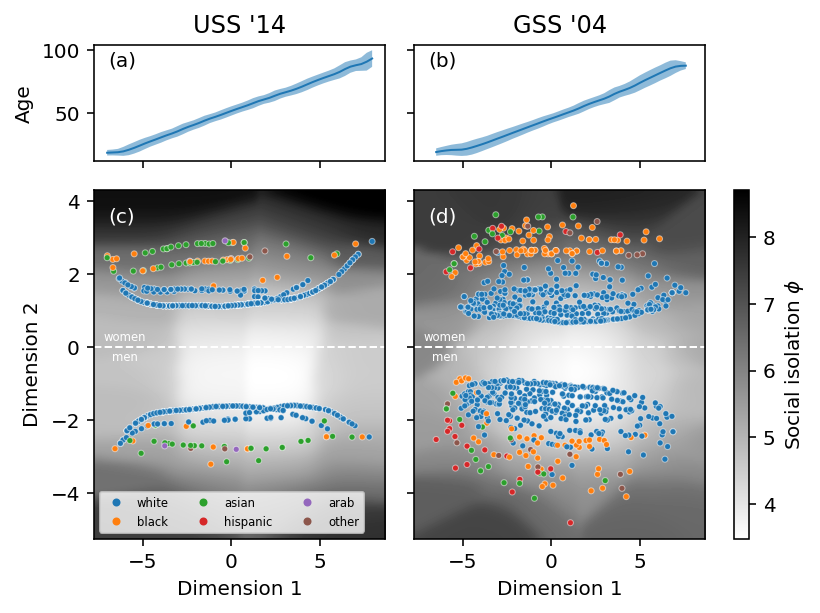

In [30]:
# Set up the figure
ethnicities = ['white', 'black', 'asian', 'hispanic', 'arab', 'other']
color_by_ethnicity = {x: 'C%d' % i for i, x in enumerate(ethnicities)}
gridspec_kw = {
    'height_ratios': [1, 3],
    'width_ratios': [1, 1, .05],
}
fig = plt.figure()
gspec = gridspec.GridSpec(2, 3, figure=fig, **gridspec_kw)

ax_age1 = fig.add_subplot(gspec[0, 0])
ax_age2 = fig.add_subplot(gspec[0, 1], sharex=ax_age1, sharey=ax_age1)
ax_embed1 = fig.add_subplot(gspec[1, 0], sharex=ax_age1)
ax_embed2 = fig.add_subplot(gspec[1, 1], sharex=ax_embed1, sharey=ax_embed1)
axes = np.asarray([
    [ax_age1, ax_age2],
    [ax_embed1, ax_embed2],
])

# Find the ranges of the data
(xmin, xmax) = kernels.exrange(embedding_usoc['x'], embedding_gss['x'], factor=0.05)
(ymin, ymax) = kernels.exrange(embedding_usoc['y'], embedding_gss['y'], factor=0.05)
extent = (xmin, xmax, ymin, ymax)

# Precompute the heatmaps so we can figure out the shared range
isolations = []
scale = 0.5
for embedding in [embedding_usoc, embedding_gss]:
    x = embedding['x']
    y = embedding['y']
    linx = np.linspace(xmin, xmax)
    liny = np.linspace(ymin, ymax)
    xx, yy = np.meshgrid(linx, liny, indexing='ij')
    chi2 = ((xx[..., None] - x) ** 2 + (yy[..., None] - y) ** 2) / scale ** 2
    weight = np.exp(-chi2)
    mean_isolation = np.sum(weight * embedding['isolation'], axis=-1) / np.sum(weight, axis=-1)
    isolations.append(mean_isolation)
    
vmin = np.min(isolations)
vmax = np.max(isolations)

for i, embedding in enumerate([embedding_usoc, embedding_gss]):
    # Transform to align with axes
    mds = embedding['mds']
    z = embedding['z']
    x = embedding['x']
    y = embedding['y']
    
    ax1, ax2 = axes[:, i]
    
    # Plot the mean age
    linx = np.linspace(x.min(), x.max())
    chi2 = np.square((linx[:, None] - x) / scale)
    weight = np.exp(-chi2)
    mean = np.dot(weight, z['age']) / np.sum(weight, axis=1)
    square = np.dot(weight, np.square(z['age'])) / np.sum(weight, axis=1)
    std = np.sqrt(square - np.square(mean))
    
    ax1.plot(linx, mean)
    factor = 1.96  # 95% confidence interval
    ax1.fill_between(linx, mean - factor * std, mean + factor * std, alpha=.5)
    
    # Plot the isolation in the background
    im = ax2.imshow(isolations[i], interpolation='bicubic', cmap='gray_r', origin='lower', 
                    extent=extent, aspect='auto', vmin=vmin, vmax=vmax)
    
    # Get the ethnicity colours
    if i == 1:
        c = [color_by_ethnicity[x] for x in z['ethnicity']]
    elif True:
        c = []
        for i in range(len(z)):
            current = None
            for ethnicity in reversed(ethnicities):
                field = 'ethnicity_' + ethnicity 
                if field not in z.dtype.fields:
                    continue
                if z[field][i] > 0:
                    current = ethnicity
                    break
            
            if not current:
                raise ValueError
            c.append(color_by_ethnicity[current])
    else:
        c = None
            
    path = ax2.scatter(x, y, c=c)
    path.set_edgecolor((1, 1, 1, .5))
    path.set_linewidth(.5)
    
axes[0, 0].set_ylabel('Age')
axes[0, 0].set_title("USS '14")
axes[0, 1].set_title("GSS '04")
axes[1, 0].set_ylabel('Dimension 2')
for ax in axes[1]:
    ax.set_xlabel('Dimension 1')
    
# Hide ticklabels for shared axes
for ax in axes[0]:
    plt.setp(ax.get_xticklabels(), visible=False)
for ax in axes[:, 1]:
    plt.setp(ax.get_yticklabels(), visible=False)

elements = [
    Line2D([0], [0], color=c, label=e, marker='.', ls='none') 
    for e, c in color_by_ethnicity.items()
]
axes[1, 0].legend(handles=elements, ncol=3, loc='lower left', 
                  fontsize='xx-small')

division_color = 'w'
kwargs = {
    'color': division_color,
    'fontsize': 'xx-small',
    'ha': 'center',
}
for ax in axes[1]:
    ax.axhline(0, c=division_color, ls='--')
    ax.text(xmin + 1.75, 0.1, 'women', va='bottom', **kwargs)
    ax.text(xmin + 1.75, -0.1, 'men', va='top', **kwargs)
    
    
kernels.label_axes(axes[0, :2])
kernels.label_axes(axes[1, :2], offset=2, color='w')

cb = plt.colorbar(im, cax=fig.add_subplot(gspec[1, 2]))
cb.set_label(r'Social isolation $\phi$')

fig.tight_layout()
fig.savefig('../manuscript/embedding.pdf')

In [22]:
# Generate summary statistics of isolation for ethnic majority and minority
for key in ['USS \'14', 'GSS \'04']:
    result = results[key]
    excluded_fields = ['distance']
    np.random.seed(0)
    xs = result['samples']['xs']
    egos = np.random.choice(result['data']['egos'], n, False)
    z = result['data']['z'][egos]
    feature_map = result['data']['feature_map']

    i, j = np.triu_indices(len(egos), k=1)
    features = feature_map(z[i], z[j])
    reference = feature_map(z[j], z[j])

    for field in excluded_fields:
        if field in features.dtype.fields:
            features[field] = reference[field] = 0

    params = dict(zip(result['feature_names'], result['laplace_approximation']['x']))
    condensed = (structured_to_unstructured(reference) - structured_to_unstructured(features)) / result['scales']

    print(key)
    features = np.empty((len(egos), len(egos), condensed.shape[1]))
    features[i, j] = features[j, i] = condensed
    mean_features = features.sum(axis=0) / (len(egos) - 1)
    isolation = mean_features.dot(xs.T)

    if 'ethnicity_white' in z.dtype.fields:
        fltr = z['ethnicity_white'] == 1
    else:
        fltr = z['ethnicity'] == 'white'

    for f in [fltr, ~fltr]:
        mean_isolation = isolation[f].mean(axis=0)
        percentiles = [2.5, 50, 97.5]
        p2_5, median, p97_5 = [np.percentile(mean_isolation, q) for q in percentiles]
        print(f'{median:.2f}, {p2_5:.2f}, {p97_5:.2f}')

USS '14
4.53, 4.47, 4.59
4.99, 4.91, 5.07
GSS '04
4.46, 4.10, 4.84
5.16, 4.73, 5.58


# Coefficient and age-equivalents plots

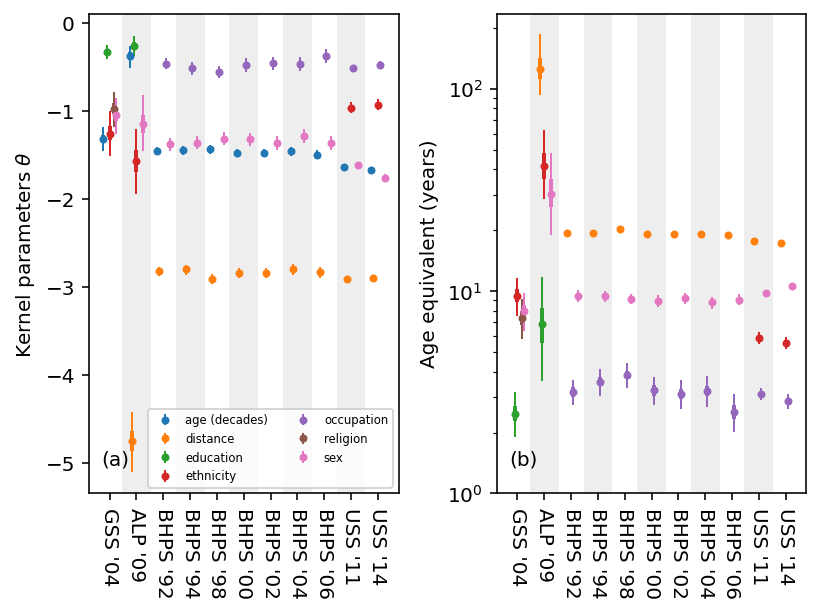

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

# Evaluate the equivalents
equivalents = {}
coeffs = {}
features = set()
for key, result in results.items():
    if result is None:
        continue
    # add the features to the list
    features.update(result['feature_names'])
    # Calculate the equivalents
    samples = result['samples']['xs']
    original = samples / result['scales']
    age_idx = result['feature_names'].index('age')
    age = original[:, age_idx]
    equivalent = original / age[:, None]
    equivalent = dict(zip(result['feature_names'], equivalent.T))
    equivalents[key] = equivalent
    coeffs[key] = dict(zip(result['feature_names'], original.T))
features.remove('bias')

# Plot the equivalents
x = np.arange(len(results))

# Plot background
for i in x:
    if i % 2:
        for ax in (ax1, ax2):
            ax.axvspan(i - 0.5, i + 0.5, color='#eee')

percentiles = [2.5, 25, 50, 75, 97.5]
            
for i, feature in enumerate(sorted(features)):
    for ax, group in zip((ax1, ax2), (coeffs, equivalents)):
        values = np.asarray([group[dataset].get(feature) for dataset in results])
        if feature == 'age':
            if ax is ax2:
                continue
            values *= 10
            feature = 'age (decades)'
        
        p2_5, p25, median, p75, p97_5 = np.asarray([
            [np.nan if value is None else np.percentile(value, q) for value in values] 
            for q in percentiles
        ])

        kwargs = {
            'color': f'C{i}',
            'ls': 'none',
        }
        y = median
        offset = 0.25 * (2 * i / (len(features) - 1) - 1)
        ax.errorbar(x + offset, y, (y - p25, p75 - y), **kwargs, lw=2)
        ax.errorbar(x + offset, y, (y - p2_5, p97_5 - y), **kwargs, marker='.', label=feature)
    
kernels.label_axes((ax1, ax2), y=0.05, x=0.04, va='bottom')
    
ax2.set_yscale('log')
ax2.xaxis.set_ticks(x)
ax2.xaxis.set_ticklabels(list(results), rotation=-90)
ax2.set_ylabel('Age equivalent (years)')
ax2.set_ylim(bottom=1)

ax1.legend(loc='best', fontsize='xx-small', ncol=2)
plt.setp(ax1.xaxis.get_ticklabels(), rotation=-90)
ax1.set_ylabel(r'Kernel parameters $\theta$')
# ax1.set_yscale('log')

fig.tight_layout()
fig.savefig('../manuscript/coefficients-age-equivalent.pdf')

# Global segregation plot

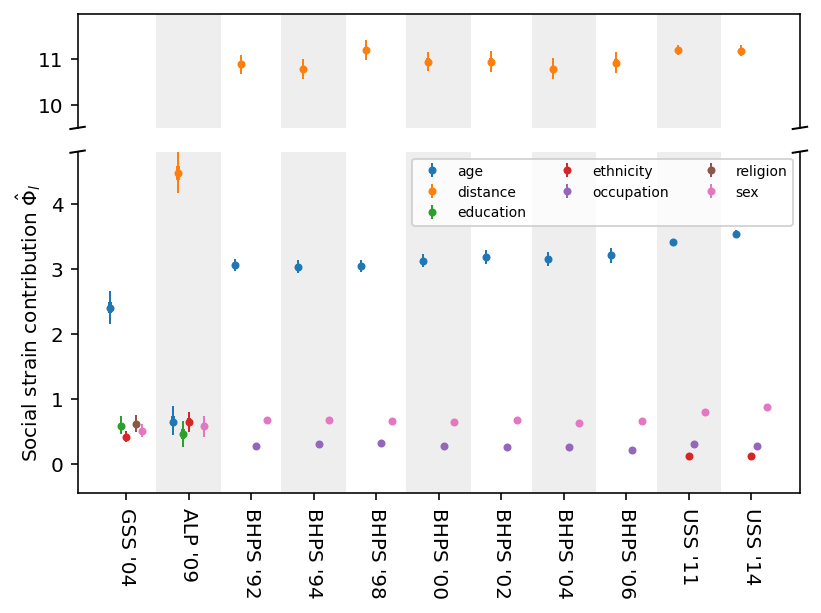

In [25]:
ratios = [1, 3]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={
    'height_ratios': ratios,
    # 'hspace': 0.05,
})

# Evaluate the global segregation
segregations = {}
features = set()
for key, result in results.items():
    # add the features to the list
    features.update(result['feature_names'])
    # Calculate the equivalents
    samples = result['samples']['xs']
    segregation = - result['offsets'] / result['scales'] * samples
    segregation = dict(zip(result['feature_names'], segregation.T))
    segregations[key] = segregation
features.remove('bias')

# Plot the equivalents
x = np.arange(len(results))

for ax in (ax1, ax2):
    # Plot background
    for i in x:
        if i % 2:
            ax.axvspan(i - 0.5, i + 0.5, color='#eee')

    for i, feature in enumerate(sorted(features)):
        values = np.asarray([segregations[dataset].get(feature) for dataset in results])
        
        percentiles = [2.5, 25, 50, 75, 97.5]
        p2_5, p25, median, p75, p97_5 = np.asarray([
            [np.nan if value is None else np.percentile(value, q) for value in values] 
            for q in percentiles
        ])

        kwargs = {
            'color': f'C{i}',
            'ls': 'none',
        }
        y = median
        offset = 0.25 * (2 * i / (len(features) - 1) - 1)
        ax.errorbar(x + offset, y, (y - p25, p75 - y), **kwargs, lw=2)
        ax.errorbar(x + offset, y, (y - p2_5, p97_5 - y), **kwargs, marker='.', label=feature)
        
ax1.xaxis.tick_top()
ax1.spines['bottom'].set_visible(False)
plt.setp(ax1.xaxis.get_ticklines(), visible=False)
ax2.spines['top'].set_visible(False)

d = 0.01
kwargs = {
    'transform': ax1.transAxes,
    'color': 'k',
    'clip_on': False,
}
ax1.plot((-d, d), (-d, d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, d), **kwargs)

factor = ratios[0] / ratios[1]
kwargs['transform'] = ax2.transAxes
ax2.plot((-d, d), (1-factor * d, 1+factor * d), **kwargs)
ax2.plot((1 - d, 1 + d), (1-factor * d, 1+factor * d), **kwargs)

ax2.set_ylim(top=4.8)
ax1.set_ylim(bottom=9.5)
    
ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(list(results), rotation=-90)
ax.set_ylabel(r'Social strain contribution $\hat\Phi_l$')
ax.legend(loc='best', ncol=3, fontsize='x-small')
fig.tight_layout()
fig.savefig('../manuscript/segregation.pdf')

# Table of statistics

In [8]:
def format_percent(value, decimals=1):
    if value == 0:
        return f'0.' + '0' * decimals
    rounded = np.round(value, decimals)
    if rounded == 0:
        return f'\\textless {10**(-decimals)}'
    elif rounded == 100:
        return f'>{1-10**(-decimals)}'
    else:
        return str(rounded)
        

lines = [[
    'Dataset',
    'Egos',
    'Dropped egos',
    'Alters',
    'Dropped alters',
]]

for key, result in results.items():
    data = result['data']
    
    negos = len(data['egos'])
    egos_missing = collections.Counter(data['invalid_egos']._invalid)
    egos_partial = egos_missing.get('some values missing', 0)
    
    nalters = len(data['alters'])
    alters_missing = collections.Counter(data['invalid_alters']._invalid)
    alters_partial = alters_missing.get('some values missing', 0)
    
    print(key)
    print('egos')
    print(egos_missing)
    print('alters')
    print(alters_missing)
    print()
    
    lines.append([
        key, 
        f'{negos:,}',
        f'{egos_partial:,} ({format_percent(100 * egos_partial / (egos_partial + negos))}\\%)',
        f'{nalters:,}',
        f'{alters_partial:,} ({format_percent(100 * alters_partial / (alters_partial + nalters))}\\%)',
    ])

print('\\\\\n'.join([' & '.join(line) for line in lines]))

GSS '04
egos
Counter({'some values missing': 38})
alters
Counter({'not a friend': 11304, 'relative': 1542, 'some values missing': 158, 'age < 18': 3})

ALP '09
egos
Counter({'age < 18': 39})
alters
Counter({'all values missing': 6306, 'relative: partner': 1267, 'relative: parent': 1102, 'relative: child': 870, 'some values missing': 315, 'age < 18': 14})

BHPS '92
egos
Counter({'zero weight': 386, 'age < 18': 336, 'job: something else': 17, 'some values missing': 1})
alters
Counter({'is relative': 5637, 'all values missing': 2817, 'some values missing': 506, 'age < 18': 136})

BHPS '94
egos
Counter({'zero weight': 424, 'age < 18': 319, 'some values missing': 5, 'job: something else': 5})
alters
Counter({'is relative': 5817, 'all values missing': 2428, 'some values missing': 469, 'age < 18': 142})

BHPS '98
egos
Counter({'zero weight': 2012, 'age < 18': 294, 'job: something else': 11, 'some values missing': 5})
alters
Counter({'is relative': 6142, 'all values missing': 1946, 'some value

# Synthetic inference plots

In [14]:
filenames = glob.glob('../workspace/synthetic/*.pkl')
results = []
for filename in tqdm(filenames):
    result = load_result(filename, print_=False)
    # Don't retain the entire result to save memory
    results.append({
        'laplace_approximation': result['laplace_approximation'],
        'data': {
            'theta': result['data']['theta'],
            'pairs': result['data']['pairs'],
            'egos': result['data']['egos'],
        }
    })

In [15]:
chi2s = []
degrees = []
for result in results:
    x = result['laplace_approximation']['x']
    cov = result['laplace_approximation']['cov']
    residual = result['data']['theta'] - x
    chi2 = residual.dot(np.linalg.inv(cov)).dot(residual)
    chi2s.append(chi2)
    degrees.append(len(result['data']['pairs']) / len(result['data']['egos']))
pvals = stats.chi2(3).cdf(chi2s)

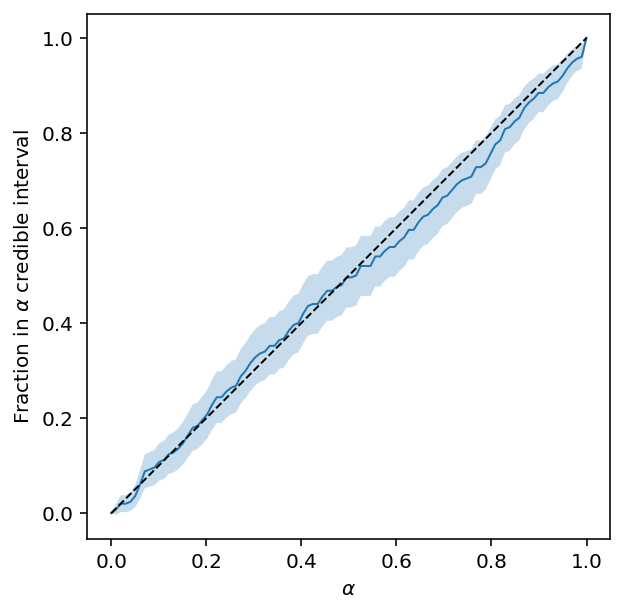

In [16]:
fig, ax = plt.subplots()

alphas = np.linspace(0, 1, 100)
indicator = pvals[:, None] < alphas
y = np.mean(indicator, axis=0)
yerr = np.std(indicator, axis=0) / np.sqrt(len(indicator))
ax.plot(alphas, y)
ax.plot(alphas, alphas, ls='--', color='k')
factor = 2
ax.fill_between(alphas, y - factor * yerr, y + factor * yerr, alpha=.25)
ax.set_aspect('equal')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'Fraction in $\alpha$ credible interval')
fig.tight_layout()
fig.savefig('../manuscript/credible-coverage.pdf')